In [4]:
import sys
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

font = {'size'   : 14}
mpl.rc('font', **font)

import numpy as np
import pandas as pd

from scipy import stats
import sklearn
import sklearn.cluster


In [18]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import louvain
import graphtools as gt

# Comparison of clustering algorithms on toy data

Here we're going to compare three clustering algorithms on toy data. The code for this exercise is adapted from: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

### Generating data

Here we're going to work with 6 datasets all in $\mathbb{R}^2$ 

1. **Circles** - two circles, one circumscribed by the other
2. **Moons** - Two interleaving half circles
3. **Varied variance blobs** - These blobs each have different variances
4. **Anisotropically distributed blobs** - these blobs have unequal widths and lengths
5. **Regular blobs** - Just three regular blobs
6. **Uniformly sampled square** - Just a single square

Because we're generating these from scratch, we get to change some parameters of their distributions. Generally, we can change:
1. `noise` - the amount of Gaussian noise added to each point
2. `n_samples` - the number of points generated
3. `factor` / `cluster_std` - some parameters affecting shape

In [53]:
np.random.seed(0)
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500

# Circles
noisy_circles = datasets.make_circles(n_samples=n_samples, 
                        # Scale factor between inner and outer circle
                        factor=.5,
                        # Gaussian noise added to each point
                        noise=.05)

# Moons
noisy_moons = datasets.make_moons(n_samples=n_samples, 
                                  noise=.05)

# Blobs
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

# Uniform square
no_structure = np.random.rand(n_samples, 2), None

# Anisotropically distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
# Changes how x1, x2 coordinates are shifted
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Associate each dataset with the correct # of clusters
# ============

default_base = {'n_clusters': 3}

generated_datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied,      {}),
    (aniso,       {}),
    (blobs, {}),
    (no_structure, {})]

#### Plot ground truth cluster assignments

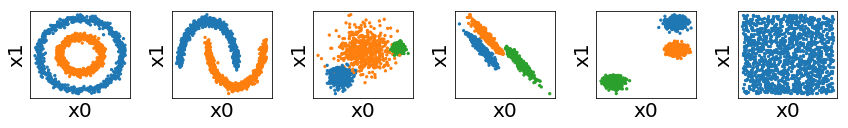

In [57]:
fig, axes = plt.subplots(1,6,figsize=(12,2))

for i, (dataset, _) in enumerate(generated_datasets):
    ax = axes[i]
    X, y = dataset
    
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    scprep.plot.scatter2d(X, c=y, 
                          ticks=None, ax=ax, 
                          xlabel='x0', ylabel='x1',
                         legend=False)
    
fig.tight_layout()

### Run clustering algorithms and plot results

This is a lot of code, so make sure you and your partner go through and understand what's going on.

/usr/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


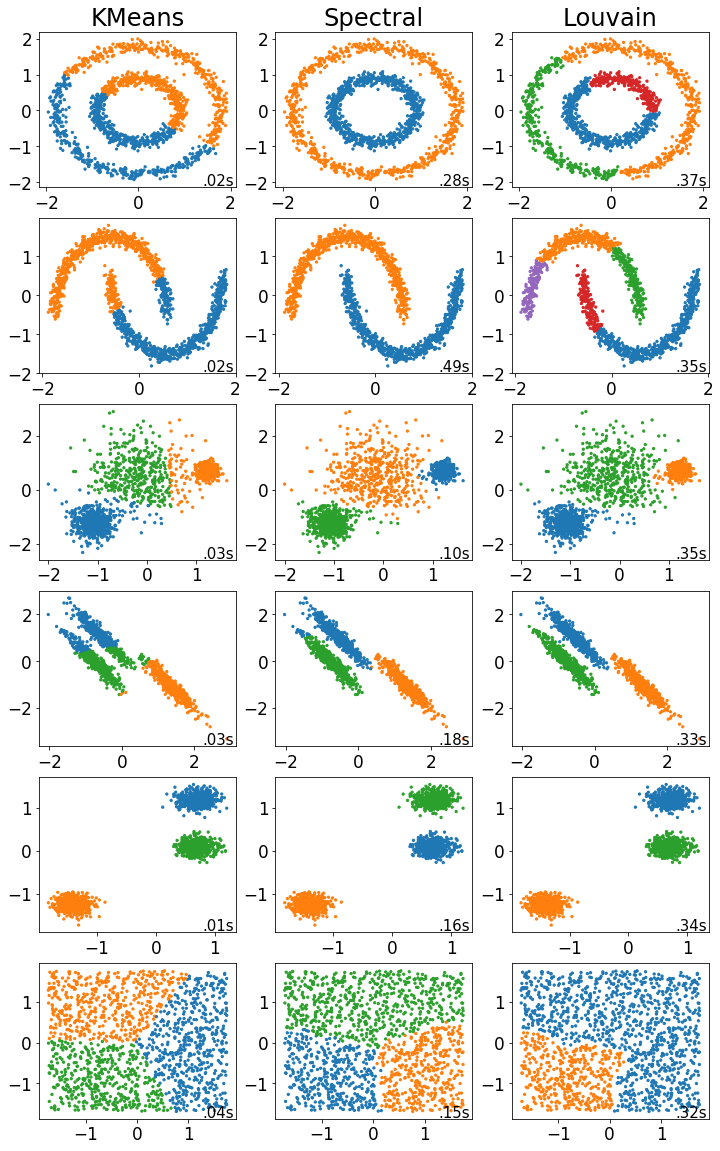

In [58]:


fig, axes = plt.subplots(6,3, figsize=(12, 20))
plot_title = True

for i_dataset, (dataset, cluster_params) in enumerate(generated_datasets):
    # update cluster parameters with dataset-specific values
    params = default_base.copy()
    params.update(cluster_params)

    X, y = dataset
    
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
        
    # ============
    # Run clustering algorithms
    # ============
    clusters = []
    titles = []
    times = []
    # KMeans
    tic = time.time()
    kmeans = cluster.KMeans(n_clusters=params['n_clusters'])
    clusters.append(kmeans.fit_predict(X))
    titles.append('KMeans')
    times.append(time.time() - tic)
    
    # Spectral Clustering
    tic = time.time()
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    clusters.append(spectral.fit_predict(X))
    titles.append('Spectral')
    times.append(time.time() - tic)

    
    # Louvain
    tic = time.time()
    G = gt.Graph(X)
    G_igraph = G.to_igraph()
    part = louvain.find_partition(G_igraph, louvain.RBConfigurationVertexPartition, 
                                  weights="weight", resolution_parameter=0.01)
    clusters.append(np.array(part.membership))
    titles.append('Louvain')
    times.append(time.time() - tic)

    # ============
    # Plot clustering results for dataset
    # ============
    row_axes = axes[i_dataset]
    
    for i, ax in enumerate(row_axes.flatten()):
        curr_cluster = clusters[i]
        if plot_title:
            curr_title = '{}'.format(titles[i])
        else:
            curr_title = None
            
        scprep.plot.scatter2d(X, c=curr_cluster, title=curr_title, ax=ax,
                             legend=False, discrete=True)

        # Plot time to run algorithm
        plt.text(.99, .01, ('%.2fs' % (times[i])).lstrip('0'),
                 transform=ax.transAxes, size=15,
                 horizontalalignment='right')
    plot_title=False
fig.tight_layout()
fig.savefig('../img/cluster_comparison.png', dpi=300)

In [15]:
import scprep

In [29]:
louvain.find_partition()

<module 'louvain' from '/home/dan/.local/lib/python3.7/site-packages/louvain/__init__.py'>